In [36]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [10]:
try:
    with open ("../config.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')

In [11]:
sys.path.insert(0, os.path.abspath(config['lib']))

## Setting directories, showing some pictures

In [ ]:
data_dir = ('../data/raw/Training')
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']
for i in categories:
    path = os.path.join(data_dir, i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img)) 

In [ ]:
plt.imshow(img_array);

In [ ]:
img_array.shape

In [ ]:
plt.figure(figsize=(20, 16))

images_path = ['/glioma/Tr-glTr_0000.jpg', '/meningioma/Tr-meTr_0000.jpg', '/notumor/Tr-noTr_0000.jpg', '/pituitary/Tr-piTr_0000.jpg']

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    img = cv2.imread(data_dir + images_path[i])
    img = cv2.resize(img, (250, 250))
    plt.imshow(img)
    plt.title(categories[i])

## MODEL 1

In [43]:
model1 = Sequential()

# Layer 1
model1.add(Conv2D(32,(3,3), input_shape=(64, 64, 1), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

# Layer 2
model1.add(Conv2D(32,(3,3), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2)))

model1.add(Flatten())


# Neural network
model1.add(Dense(units= 252, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=252, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(units=4, activation='softmax'))


model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 29, 29, 32)       128       
 hNormalization)                                                 
                                                        

In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,  clipvalue=0.5)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])

generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False) 

generator_test = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

train = generator_train.flow_from_directory('../data/raw/Training', target_size=(64,64),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

test = generator_test.flow_from_directory('../data/raw/Testing', target_size=(64,64),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
model1_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model1_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model1_mcp = ModelCheckpoint(filepath = '../models/model1_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 2)

history1 = model1.fit(train, steps_per_epoch=5712//32, epochs=10, validation_data=test, validation_steps= 1311//32,
                     callbacks=[model1_es, model1_rlr, model1_mcp])

In [ ]:
model1.evaluate(test)

In [ ]:
#Run this code to save the Model 1
#model1.save('../models/model1.model')

## MODEL 2

In [ ]:
model2 = Sequential()

# Layer 1
model2.add(Conv2D(64,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

# Layer 2
model2.add(Conv2D(128,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

# Layer 3
model2.add(Conv2D(256,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

# Layer 4
model2.add(Conv2D(512,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Flatten())


# Connect layers
model2.add(Dense(units= 512, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=512, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(units=4, activation='softmax'))


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])


model2.summary()

In [ ]:
generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

generator_test = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)


train = generator_train.flow_from_directory('../data/raw/Training', target_size=(64,64),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

test = generator_test.flow_from_directory('../data/raw/Testing', target_size=(64,64),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

In [ ]:
model2_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model2_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model2_mcp = ModelCheckpoint(filepath = '../models/model2_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

history2 = model2.fit(train, steps_per_epoch=5712//32, epochs=5, validation_data=test, validation_steps= 1311//32,
                      callbacks=[model2_es, model2_rlr, model2_mcp])

In [ ]:
model2.evaluate(test)

In [ ]:
#Run this code to save the Model 2
#model2.save('../models/model2.model')

## MODEL 3

In [ ]:
model3 = Sequential()

# Layer 1
model3.add(Conv2D(64,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

# Layer 2
model3.add(Conv2D(64,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

# Layer 3
model3.add(Conv2D(64,(7,7), input_shape=(64, 64, 1), padding='same', activation='relu'))
model3.add(BatchNormalization())
model3.add(MaxPooling2D(pool_size=(2,2)))

model3.add(Flatten())


# Connect layers
model3.add(Dense(units= 512, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(units=512, activation='relu'))
model3.add(Dropout(0.2))
model3.add(Dense(units=4, activation='softmax'))


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)
model3.compile(optimizer=optimizer, loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])


model3.summary()

In [ ]:
generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

generator_test = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)


train = generator_train.flow_from_directory('../data/raw/Training', target_size=(64,64),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

test = generator_test.flow_from_directory('../data/raw/Testing', target_size=(64,64),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

In [ ]:
model3_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model3_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model3_mcp = ModelCheckpoint(filepath = '../models/model3_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

history3 = model3.fit(train, steps_per_epoch=5712//32, epochs=100, validation_data=test, validation_steps= 1311//32,
                     callbacks=[model3_es, model3_rlr, model3_mcp])

In [ ]:
model3.evaluate(test)

In [ ]:
#Run this code to save the Model 3
#model3.save('../models/model3.model')

## MODEL 4

In [ ]:
model4 = Sequential()

# Layer 1
model4.add(Conv2D(64,(7,7), input_shape=(200, 200, 1), padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))

# Layer 2
model4.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))

# Layer 3
model4.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))

# Layer 4
model4.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))

# Layer 5
model4.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))

# Layer 6
model4.add(Conv2D(512,(7,7), padding='same', activation='relu'))
model4.add(BatchNormalization())
model4.add(MaxPooling2D(pool_size=(2,2)))

model4.add(Flatten())


# Connect layers
model4.add(Dense(units= 1024, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(units=1024, activation='relu'))
model4.add(Dropout(0.3))
model4.add(Dense(units=4, activation='softmax'))


model4.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])


model4.summary()

In [ ]:
generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

generator_test = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)



train = generator_train.flow_from_directory('../data/raw/Training', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

test = generator_test.flow_from_directory('../data/raw/Testing', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

In [ ]:
model4_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model4_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model4_mcp = ModelCheckpoint(filepath = '../models/model4_weights.h5', monitor = 'val_accuracy_score', 
                      save_best_only = True, verbose = 1)

history4 = model4.fit(train, steps_per_epoch=5712//32, epochs=50, validation_data=test, validation_steps= 1311//32,
                     callbacks=[model4_es, model4_rlr, model4_mcp])

In [ ]:
model4.evaluate(test)

In [ ]:
#Run this code to save the Model 4
#model4.save('../models/model4.model')

## MODEL 5

In [ ]:
model5 = Sequential()

# Layer 1
model5.add(Conv2D(64,(7,7), input_shape=(200, 200, 1), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

# Layer 2
model5.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

# Layer 3
model5.add(Conv2D(128,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

# Layer 4
model5.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

# Layer 5
model5.add(Conv2D(256,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

# Layer 6
model5.add(Conv2D(512,(7,7), padding='same', activation='relu'))
model5.add(BatchNormalization())
model5.add(MaxPooling2D(pool_size=(2,2)))

model5.add(Flatten())


# Connect layers
model5.add(Dense(units= 1024, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(units=512, activation='relu'))
model5.add(Dropout(0.25))
model5.add(Dense(units=4, activation='softmax'))


model5.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy',
                   metrics= ['categorical_accuracy'])


model5.summary()

In [ ]:
generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

generator_test = ImageDataGenerator(rescale=1./255,
                                   featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=0,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)



train = generator_train.flow_from_directory('../data/raw/Training', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

test = generator_test.flow_from_directory('../data/raw/Testing', target_size=(200, 200),
                                              batch_size=32, class_mode= "categorical", color_mode='grayscale')

In [ ]:
model5_es = EarlyStopping(monitor = 'loss', min_delta = 1e-11, patience = 12, verbose = 1)
model5_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model5_mcp = ModelCheckpoint(filepath = '../models/model5_weights.h5', monitor = 'val_categorical_accuracy', 
                      save_best_only = True, verbose = 1)

history5 = model5.fit(train, steps_per_epoch=5712//32, epochs=50, validation_data=test, validation_steps= 1311//32,
                     callbacks=[model5_es, model5_rlr, model5_mcp])

In [ ]:
classes = train.class_indices

In [ ]:
print(classes)

In [ ]:
model5.evaluate(test)

In [ ]:
#Run this code to save the Model 5
#model5.save('../models/model5.model')

# DO NOT RUN THE FOLLOWING CELLS IF THE MODELS 1-4 WERE ALREADY SAVED

These were run here due to an issue with the web browser crashing during model 5 execution, fortunately python kept running in the background and model managed to finish successfully.

In [ ]:
#model1.save('../models/model1.model')

In [ ]:
#model2.save('../models/model2.model')

In [ ]:
#model3.save('../models/model3.model')

In [ ]:
#model4.save('../models/model4.model')

# Models performance graphs

In [ ]:
#Plotting only the models that managed to finish. Since model 4 was interrupted it didn´t save history, so I have plotted only 1, 2, 3 and 5.

fig, axs = plt.subplots(4, 2, figsize=(20,18))

axs[0, 0].plot(history1.history["loss"],c = "purple")
axs[0, 0].plot(history1.history["val_loss"],c = "orange")
axs[0, 0].set_ylim([-0.1,2])
axs[0, 0].legend(["train", "test"])
axs[0, 0].set_title('Model 1 Loss')

axs[0, 1].plot(history1.history["categorical_accuracy"],c = "purple")
axs[0, 1].plot(history1.history["val_categorical_accuracy"],c = "orange")
axs[0, 1].set_ylim([0.8,1.1])
axs[0, 1].legend(["train", "test"])
axs[0, 1].set_title('Model 1 Accuracy')

axs[1, 0].plot(history2.history["loss"],c = "purple")
axs[1, 0].plot(history2.history["val_loss"],c = "orange")
axs[1, 0].set_ylim([-0.1,2])
axs[1, 0].legend(["train", "test"])
axs[1, 0].set_title('Model_2 Loss')

axs[1, 1].plot(history2.history["categorical_accuracy"],c = "purple")
axs[1, 1].plot(history2.history["val_categorical_accuracy"],c = "orange")
axs[1, 1].set_ylim([0.5,1.1])
axs[1, 1].legend(["train", "test"])
axs[1, 1].set_title('Model_2 Acurracy')

axs[2, 0].plot(history3.history["loss"],c = "purple")
axs[2, 0].plot(history3.history["val_loss"],c = "orange")
axs[2, 0].set_ylim([-0.1,2])
axs[2, 0].legend(["train", "test"])
axs[2, 0].set_title('Model_3 Loss')

axs[2, 1].plot(history3.history["categorical_accuracy"],c = "purple")
axs[2, 1].plot(history3.history["val_categorical_accuracy"],c = "orange")
axs[2, 1].set_ylim([0.8,1.1])
axs[2, 1].legend(["train", "test"])
axs[2, 1].set_title('Model 3 Accuracy')

axs[3, 0].plot(history5.history["loss"],c = "purple")
axs[3, 0].plot(history5.history["val_loss"],c = "orange")
axs[3, 0].set_ylim([-0.1,2])
axs[3, 0].legend(["train", "test"])
axs[3, 0].set_title('Model 5 Loss')

axs[3, 1].plot(history5.history["categorical_accuracy"],c = "purple")
axs[3, 1].plot(history5.history["val_categorical_accuracy"],c = "orange")
axs[3, 1].set_ylim([0.8,1.1])
axs[3, 1].legend(["train", "test"])
axs[3, 1].set_title('Model 5 Accuracy')

plt.savefig('../models/models_performance.png')

In [ ]:
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image, ImageEnhance
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import yaml

# For ML Models
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model

from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from IPython.core.display import Image

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import random
import os
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

## Final model

In [16]:
generator_train = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    brightness_range= [0.8,1.2],
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=15,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)

generator_test = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    brightness_range= [0.8,1.2],
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=15,
                                    zoom_range = 0,
                                    width_shift_range=0,
                                    height_shift_range=0,
                                    horizontal_flip=True,
                                    vertical_flip=False)



train = generator_train.flow_from_directory(config['data']['raw']+'/Training', target_size=(128, 128),
                                              batch_size=20, class_mode= "categorical", color_mode='rgb')

test = generator_test.flow_from_directory(config['data']['raw']+'/Testing', target_size=(128, 128),
                                              batch_size=20, class_mode= "categorical", color_mode='rgb')

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [17]:
#Import VGG16 - Very Deep Convolutional Networks for Large-Scale Image Recognition
base_model = VGG16(input_shape=(128,128,3), include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Set the last vgg16 block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential(name='Brain_Tumor_Scanner')
model.add(Input(shape=(128,128,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [18]:
model.summary()

Model: "Brain_Tumor_Scanner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 15,763,908
Trainable params: 8,12

In [19]:
final_model_mcp = ModelCheckpoint(filepath = config['models']+'final_model_weights.h5', monitor = 'categorical_accuracy', 
                      save_best_only = True, verbose = 2)
final_model_es = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 12, verbose = 1)


history = model.fit(train, steps_per_epoch=5712//20, epochs=6, validation_data=test, validation_steps= 1311//32,
                    callbacks=[final_model_es, final_model_mcp])

Epoch 1/6
285/285 [==============================] - ETA: 0s - loss: 0.4698 - categorical_accuracy: 0.8226
Epoch 1: categorical_accuracy improved from -inf to 0.82256, saving model to ../models/final_model_weights.h5
285/285 [==============================] - 232s 810ms/step - loss: 0.4698 - categorical_accuracy: 0.8226 - val_loss: 0.4880 - val_categorical_accuracy: 0.8175
Epoch 2/6
285/285 [==============================] - ETA: 0s - loss: 0.2640 - categorical_accuracy: 0.9021
Epoch 2: categorical_accuracy improved from 0.82256 to 0.90214, saving model to ../models/final_model_weights.h5
285/285 [==============================] - 244s 857ms/step - loss: 0.2640 - categorical_accuracy: 0.9021 - val_loss: 0.3175 - val_categorical_accuracy: 0.8863
Epoch 3/6
285/285 [==============================] - ETA: 0s - loss: 0.1871 - categorical_accuracy: 0.9297
Epoch 3: categorical_accuracy improved from 0.90214 to 0.92973, saving model to ../models/final_model_weights.h5
285/285 [================

In [21]:
model.evaluate(test)

66/66 [==============================] - 34s 514ms/step - loss: 0.1285 - categorical_accuracy: 0.9542


[0.12846098840236664, 0.9542334079742432]

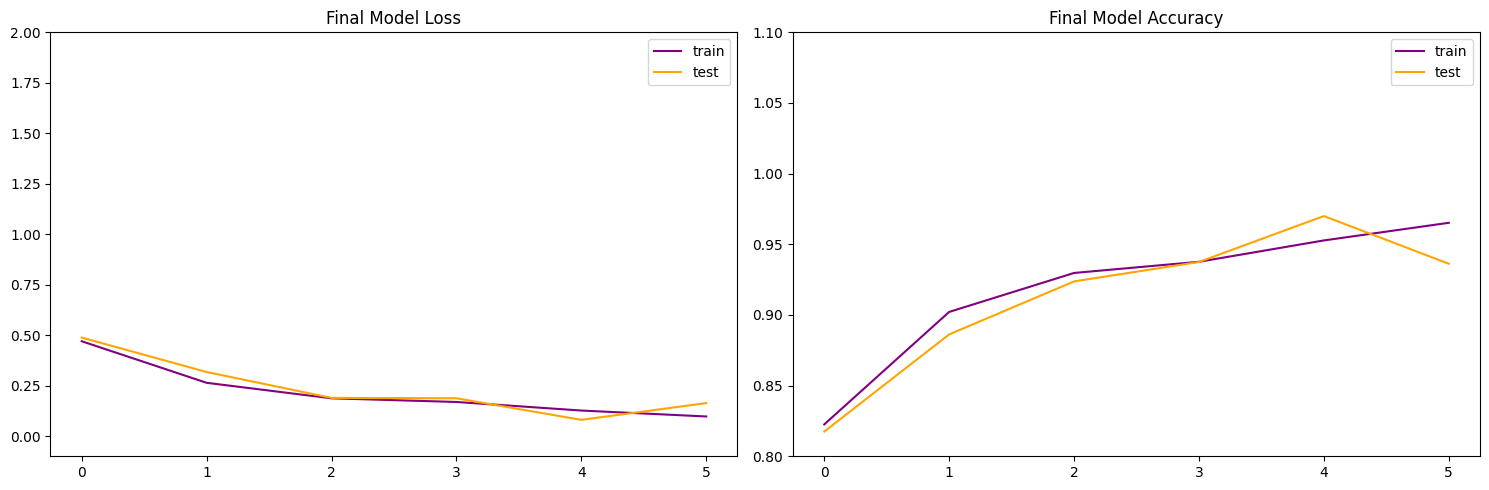

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))

axes[0].plot(history.history["loss"],c = "purple")
axes[0].plot(history.history["val_loss"],c = "orange")
axes[0].set_ylim([-0.1,2])
axes[0].legend(["train", "test"])
axes[0].set_title('Final Model Loss')

axes[1].plot(history.history["categorical_accuracy"],c = "purple")
axes[1].plot(history.history["val_categorical_accuracy"],c = "orange")
axes[1].set_ylim([0.8,1.1])
axes[1].legend(["train", "test"])
axes[1].set_title('Final Model Accuracy')

plt.tight_layout()
plt.show()

In [34]:
preds = model.predict_generator(test)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 1 2 ... 3 1 0]


In [42]:
print(classification_report(test.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.20      0.22      0.21       300
  meningioma       0.22      0.20      0.21       306
     notumor       0.32      0.32      0.32       405
   pituitary       0.23      0.23      0.23       300

    accuracy                           0.25      1311
   macro avg       0.24      0.24      0.24      1311
weighted avg       0.25      0.25      0.25      1311



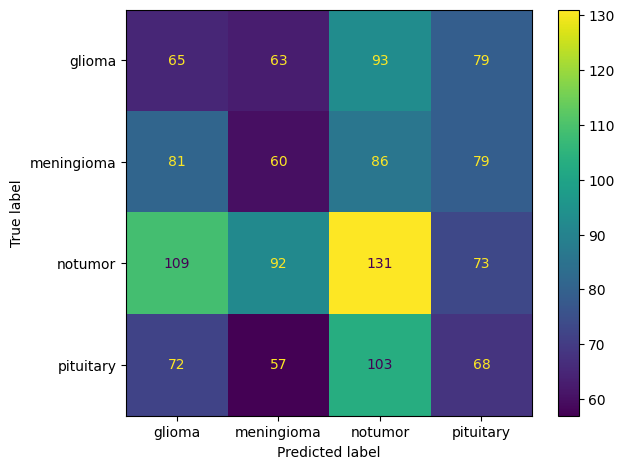

In [41]:
g_dict = test.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test.classes, y_pred)
display_cm = ConfusionMatrixDisplay(cm, display_labels=classes)
display_cm.plot()
plt.tight_layout()
plt.show()

It looks like the problem is how the images are fed into the model, since the last one achieved a much higher performance in the final_model notebook.